Calculating the training and validation set losses

We use a relatively small dataset for training the LLM (in fact, only one short story)
The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.

We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights.

For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars.

So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars

Below, we use the same dataset we used in chapter 2.

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode("utf-8")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

A quick check that the text loaded ok by printing the first and last 100 words

In [5]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [6]:
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [7]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later).

Next, we divide the dataset into a training and a validation set and use the data readers from chapter 2 to prepare the datasets for LLM training.

Since we train the LLM to predict the next word in the text, the targets look the same as these iputs, except that the targets are shifted by one position.

Implementing the DataLoader:

In [8]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [9]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [10]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-KEY-value bias
}

In [11]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    drop_last=False,
    num_workers=0
)

In [12]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Warning: The training data is smaller than the context length.")

if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Warning: The validation data is smaller than the context length.")

We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with.

Llama 2 7B was trained with a batch size of 1024, for example

An optional check that the data was loaded correctly.

In [13]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [14]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Trainning tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Trainning tokens: 4608
Validation tokens: 512
All tokens: 5120


Here is the GPT Model class we coded earlier. We will need this

In [15]:
# class GPTModel(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
#         self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
#         self.drop_emb = nn.Dropout(cfg["drop_rate"])

#         self.trf_blocks = nn.Sequential(
#             *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
#         )

#         self.final_norm = LayerNorm(cfg["emb_dim"])
#         self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

#     def forward(self, in_idx):
#         batch_size, seq_len = in_idx.shape
#         tok_embeds = self.tok_emb(in_idx)
#         pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
#         x = tok_embeds + pos_embeds
#         x = self.drop_emb(x)
#         x = self.trf_blocks(x)
#         x = self.final_norm(x)
#         logits = self.out_head(x)   
#         return logits
    
# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.eval() # disable dropout during inference

In [16]:
from llm import GPTModel

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # disable dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransoformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransoformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_featur

Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of a batches in a dataloader

In [17]:
def cal_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches
        # if numb_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.

Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(123)

# disable gradient tracking for efficient because we are not  training the model yet
with torch.no_grad():
    train_loss = cal_loss_loader(train_loader, model, device)
    val_loss = cal_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583690219456
Validation loss: 10.982394218444824


In [19]:
## Training Loop for the LLM
import torch
import time

def cal_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def cal_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches
        # if numb_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train() 

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset loss gradients from previous step
            loss = cal_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # calculate loss gradients
            optimizer.step() # update model weights using loss gradients
            tokens_seen += input_batch.numel() # returns the total number of elements (or tokens ) in the input batch
            global_step += 1

            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
    
        # print a sample text after each epoch
        # generate_and_print_sample(
        #     model, tokenizer, device, start_context
        # )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = cal_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = cal_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# def generate_and_print_sample(model, tokenizer, device, start_context):
#     model.eval()
#     context_size = model.pos_emb.weight.shape[0]
#     encoded = text_to_token_ids(start_context, tokenizer).to(device)
#     with torch.no_grad():
#         token_ids = generate_text_simple(
#             model=model,
#             idx=encoded,
#             max_new_tokens=50,
#             context_size=context_size,
#         )
#     decoded_text = token_ids_to_text(token_ids, tokenizer)
#     print(decoded_text.replace('\n', ' ')) # compat print format
#     model.train()

GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0,  # Dropout rate
    "qkv_bias": False,  # Query-KEY-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# from llm import GPTModel

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effor moves you",
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training time: {execution_time_minutes:.2f} minutes")

Ep 1 (step 000000): Train loss 9.798, Val loss 9.910
Ep 1 (step 000005): Train loss 8.047, Val loss 8.324
Ep 2 (step 000010): Train loss 6.603, Val loss 7.040
Ep 2 (step 000015): Train loss 6.000, Val loss 6.572
Ep 3 (step 000020): Train loss 5.513, Val loss 6.413
Ep 3 (step 000025): Train loss 4.585, Val loss 6.358
Ep 4 (step 000030): Train loss 3.982, Val loss 6.265
Ep 4 (step 000035): Train loss 3.655, Val loss 6.187
Ep 5 (step 000040): Train loss 2.913, Val loss 6.114
Ep 6 (step 000045): Train loss 2.497, Val loss 6.173
Ep 6 (step 000050): Train loss 1.925, Val loss 6.174
Ep 7 (step 000055): Train loss 1.650, Val loss 6.267
Ep 7 (step 000060): Train loss 1.069, Val loss 6.282
Ep 8 (step 000065): Train loss 0.747, Val loss 6.390
Ep 8 (step 000070): Train loss 0.622, Val loss 6.433
Ep 9 (step 000075): Train loss 0.431, Val loss 6.420
Ep 9 (step 000080): Train loss 0.329, Val loss 6.460
Ep 10 (step 000085): Train loss 0.252, Val loss 6.579
Training time: 7.91 minutes


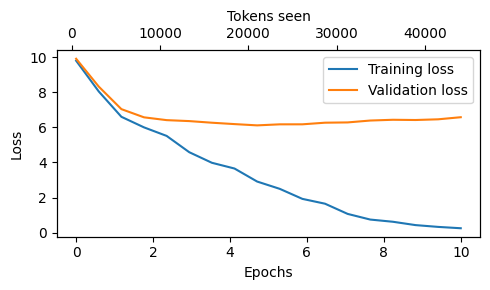

In [21]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny() # create a second x-axis sharing the same y-axis
    ax2.plot(tokens_seen, val_losses, alpha=0) # invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout() # adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(
    epochs_tensor,
    tokens_seen,
    train_losses,
    val_losses
)
